# グラフ埋め込み

In [1]:
import numpy as np
import networkx as nx

%matplotlib inline

In [2]:
DRAW_CONFIG = {
    'node_color': 'white',
    'edgecolors': 'black', # line color of nodes
    'with_labels': True,
    'node_size': 600,
    'font_size': 14,
    'font_family': 'Arial',
}

In [3]:
try:
    import torch_geometric
except:
    !pip install torch_geometric

---

## クイズ

### Q1: ランダムウォーク

以下のグラフ$G_{maze}$において，任意のノードからスタートし，ランダムウォークを$L$回したときの経路を得る関数`get_random_walk_path`を定義しなさい．
関数`get_random_walk_path`の引数はグラフ`G`，出発ノード`node_from`，経路の長さ（ランダムウォークの回数）`length`とし，返り値は`[0, 4, ..., 3]`のようなノードのリストとすること．
なお，このクイズではNetworkxの`generate_random_paths`関数は用いないこと．

※ ヒント: あるノードに隣接するノードのリストを得るには，Networkxのグラフオブジェクトの`neighbors`メソッドを用いればよい．
またリストからランダムに要素を取得するには`random`パッケージの`choice`メソッドを用いればよい．

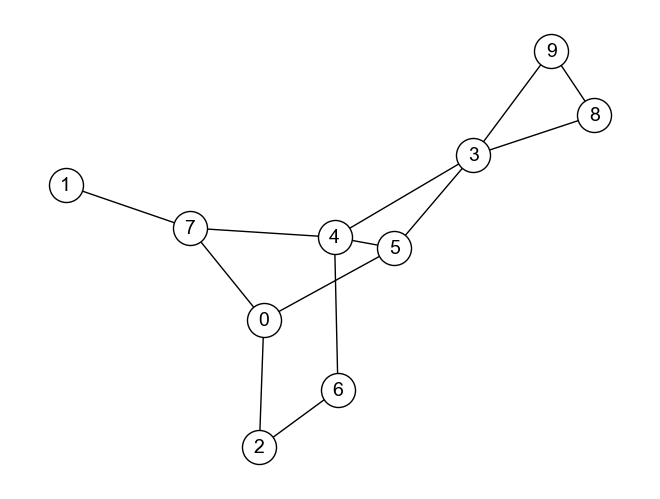

In [4]:
G_maze = nx.sedgewick_maze_graph()
G_maze.add_edges_from([(3, 8), (3, 9), (8, 9)])
pos = nx.spring_layout(G_maze, seed=123)
nx.draw(G_maze, pos, **DRAW_CONFIG)

In [5]:
import random

# Write your code
def get_random_walk_path(G, node_from, length):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''
    # 生成する経路を保存するリスト
    path = []

    # 始点ノードを追加
    path.append(node_from)

    for i in range(length):
        last_node = path[-1] # 最後に訪問したノード

        # 次に移動するノードを隣接ノードから選択
        adjacent_nodes = list(G.neighbors(last_node))
        next_node = random.choice(adjacent_nodes)

        # 経路に追加
        path.append(next_node)

    return path
        
# グラフを定義
G_maze = nx.sedgewick_maze_graph()

# 定義した関数を用いて経路を得る
path = get_random_walk_path(G_maze, node_from=1, length=5)
path

[1, 7, 0, 2, 0, 5]

### Q2: node2vecのためのランダムウォーク

クイズQ1で定義した`get_random_walk_path`関数を改良し，node2vecアルゴリズムに従うランダムウォーク経路を生成する関数`get_random_walk_path_for_n2v`を定義しなさい．
なお，関数`get_random_walk_path_for_n2v`の引数として以下を設定しなさい．
- G: グラフ
- node_from: 経路の始点となるノード
- length: 経路の長さ
- p: 再訪性パラメータ（float型）
- q: In-outパラメータ（float型）

※ ヒント: 指定した重み（確率分布）に従ってリストから要素を取得するには，`random`パッケージの`choices`関数を用いる（[参考](https://docs.python.org/ja/3.13/library/random.html#random.choices)）．

In [6]:
import random

# Write your code
def get_random_walk_path_for_n2v(G, node_from, length, p: float=1, q: float=1):
    ''' node_from: グラフG上でランダムウォークを開始するノード
        length: ランダムウォークして得る経路の長さ
    '''
    # 生成する経路を保存するリスト
    path = []

    # 始点ノードを追加
    path.append(node_from)

    for i in range(length):
        node_v = path[-1] # 最後に訪問したノード        
        
        if len(path) >= 2:
            node_t = path[-2] # node_vの前に訪問したノード
            neighbors_v = list(G.neighbors(node_v))
            neighbors_t = list(G.neighbors(node_t))
    
            # 次に移動するノードを選択するための確率分布を定義
            weights = []
            for neighbor_v in neighbors_v:
                if neighbor_v == node_t:
                    weights.append(1 / p)
                else:
                    if neighbor_v in neighbors_t:
                        weights.append(1.0)
                    else:
                        weights.append(1 / q)
                                
            # 次に移動するノードを確率分布に従い選択
            next_node = random.choices(neighbors_v, weights)[0]
    
            # 経路に追加
            path.append(next_node)
        else:
            # 次に移動するノードを隣接ノードから選択
            adjacent_nodes = list(G.neighbors(node_v))
            next_node = random.choice(adjacent_nodes)
    
            # 経路に追加
            path.append(next_node)            

    return path
        

# グラフを定義
G_maze = nx.sedgewick_maze_graph()

# 定義した関数を用いて経路を得る
path = get_random_walk_path_for_n2v(G_maze, node_from=1, length=4, p=1, q=0.01)
path

[1, 7, 0, 5, 3]

### Q3: 論文ジャンルの分類（1/2） - 埋め込みベクトルの獲得

[Cora](https://paperswithcode.com/dataset/cora)は論文公開サイト[arXiv](https://arxiv.org)で公開されている機械学習分野の論文の一部を抽出したデータセットである．
データセットには，論文の引用関係（どの論文がどの論文を引用したか）や論文のキーワード情報に加えて，各論文の分野カテゴリを示すラベル情報が含まれている．
分野カテゴリラベルは0から6までの整数値のいずれかをとり，各数値に対応する分野は以下の通りである：

0. Case based
1. Genetic algorithm
2. Neural network
3. Probabilistic method
4. Reinforcement learning
5. Rule learning
6. Theory

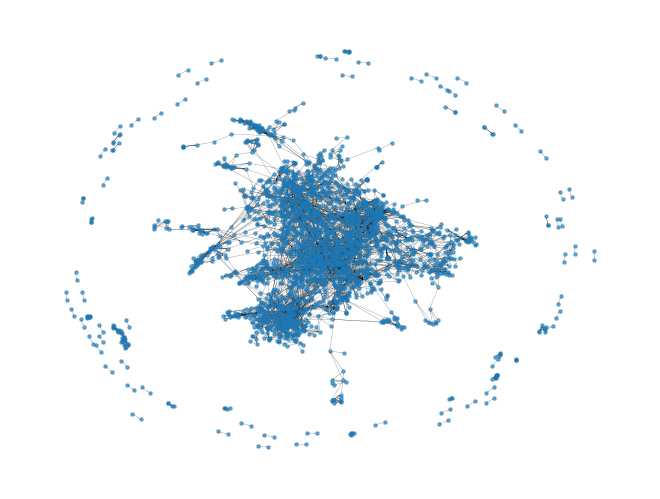

In [7]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx

# paper_datasetはPyGで扱えるグラフのデータ構造
paper_dataset = Planetoid(root="tmp", name="cora", split='full')

# NetworkXのグラフデータ構造に変換
G_paper = to_networkx(paper_dataset._data)

# 表示位置を調整して可視化
pos = nx.forceatlas2_layout(G_paper, seed=1234)
nx.draw(G_paper, pos, node_size=5, width=0.1,
        alpha=0.6, arrowsize=1, with_labels=False)

分野カテゴリが未知の論文について，そのカテゴリを推定する分類器を機械学習で構築したいとしよう．
第1ステップとして，論文の引用関係から引用関係グラフを構築し，グラフ構造とnode2vecを用いて各論文の埋め込みベクトルを得たい．
以下のPythonコードを追記，修正して，論文の埋め込みベクトルを獲得しなさい．

なお，node2vecのパラメータは以下とする:
- `embedding_dim`: 64
- `walks_per_node`: 10
- `walk_length`: 10
- `context_size`: 5
- `p`および`q`: 任意
- `epoch_num`（学習ループ回数）: 20

In [8]:
from torch_geometric.datasets import Planetoid
import torch
import torch_geometric
from torch_geometric.nn import Node2Vec

# paper_datasetはPyGで扱えるグラフのデータ構造
paper_dataset = Planetoid(root="tmp", name="cora", split='full')

# node2vecの設定
model = Node2Vec(
    paper_dataset.edge_index, # 埋め込み対象となるグラフのエッジ情報
    embedding_dim=64, # 埋め込みベクトルの次元数
    walks_per_node=10, # ノードひとつにつきランダムウォークで生成するノード系列の数
    walk_length=10, # ノード系列の長さ
    context_size=5, # word2vecを実行する際の，文脈の大きさ（周囲何ノードを対象とするか）
    p=2, # pパラメータ
    q=0.5, # qパラメータ
)

# -----------------
# 学習フェーズ
# -----------------
epoch_num = 20

# 微分最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 学習データの読み込み方法
loader = model.loader(batch_size=32, shuffle=True, num_workers=0)

# 学習
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw) # 誤差の計算
        loss.backward() # 誤差逆伝播
        optimizer.step() # パラメータ更新
        total_loss += loss.item()
    train_loss = total_loss / len(loader)
    
    if epoch % 5 == 0:
        print(f'Epoch: {epoch}, Train-loss: {train_loss:.4f}')


# -----------
# 埋め込みの取得
# -----------
# モデルを推論モードに切り替え
model.eval() 

# 行列を得る
X_n2v = model().detach().numpy()

Epoch: 0, Train-loss: 4.7598
Epoch: 5, Train-loss: 1.3170
Epoch: 10, Train-loss: 0.9027
Epoch: 15, Train-loss: 0.8251


### Q4: 論文ジャンルの分類（2/2） - 分類器の構築

Q3で得たノードの埋め込みベクトルとcoraデータセットの論文カテゴリラベルを用いて，論文のカテゴリを推定する分類器を構築したい．
ベクトルデータを入力とする機械学習手法を用いて分類器を構築し，5分割交差検証を用いて構築した分類器のマクロ適合率，マクロ再現率，マクロF1値を算出しなさい．
なお，用いる機械学習手法は自由とする．

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

# キーワード情報を取り出す
#X_keyword = paper_dataset.x.numpy()

# PCAでキーワードベクトルを圧縮
#from sklearn.decomposition import PCA
#pca = PCA(n_components=64)
#X_pca = pca.fit_transform(X_keyword)

# 分野カテゴリラベルを取り出す
y = paper_dataset.y

# 層別化
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# 交差検証の結果を格納するリスト
precisions = []
recalls = []
f1s = []

# 交差検証
for train_idx, test_idx in kfold.split(X_n2v, y):
    # train_idx, test_idxには，データフレーム中の何番目のデータを用いるかのリストが入っている．
    X_train = X_n2v[train_idx]
    X_test = X_n2v[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    # 学習．今回はサポートベクターマシンを用いる（with RBFカーネル）
    svm_model = SVC(kernel='rbf')
    svm_model.fit(X_train, y_train)

    # 推論
    y_predicted = svm_model.predict(X_test)
        
    # 評価スコアの計算
    precision = precision_score(y_test, y_predicted, average='macro')
    recall = recall_score(y_test, y_predicted, average='macro')
    f1 = f1_score(y_test, y_predicted, average='macro')

    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# 結果を集約
print(f'Mean of macro precision: {np.mean(precisions)}')
print(f'Mean of macro recall: {np.mean(recalls)}')
print(f'Mean of macro F1 score: {np.mean(f1s)}')

Mean of macro precision: 0.8378970987884765
Mean of macro recall: 0.7933183806356368
Mean of macro F1 score: 0.8111589442418905
